Import essential library 

In [ ]:
# Установка последней версии библиотеки Optuna для оптимизации гиперпараметров
#!pip install -Uq optuna

# Установка библиотеки Optuna с интеграцией для LightGBM, чтобы использовать Optuna для настройки параметров LightGBM
#!pip install -Uq optuna-integration[lightgbm]

# Установка Optuna Dashboard, чтобы иметь возможность отслеживать процесс оптимизации гиперпараметров через веб-интерфейс
#!pip install -Uq optuna-dashboard

# Установка библиотеки LightGBM через conda (канал conda-forge), включая поддержку GPU, если она доступна
#!conda install -c conda-forge lightgbm


In [1]:
import numpy as np  # для работы с массивами и математическими функциями
import pandas as pd  # для обработки и анализа данных, особенно табличных данных
import matplotlib.pyplot as plt  # для создания и настройки графиков
import seaborn as sns  # для стилизации и улучшенной визуализации графиков

import optuna  # для оптимизации гиперпараметров модели с помощью продвинутых методов поиска
import lightgbm as lgb  # для использования алгоритма градиентного бустинга LightGBM
from sklearn.model_selection import train_test_split  # для разделения данных на обучающую и тестовую выборки
from sklearn.preprocessing import StandardScaler  # для нормализации данных перед обучением
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # для оценки качества модели
from lightgbm import early_stopping  # для реализации ранней остановки в процессе обучения LightGBM


Load & Preview Data

In [2]:
# load data to Dataframe
df = pd.read_csv('C:\\Users\\ilyak\\Desktop\\Python\\Python_projects\\Материалы\\MiningProcess_Flotation_Plant_Database.csv')
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

In [4]:
# Drop date column
data_cl = df.drop('date', axis= 1)
data_cl.head(10)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136","249,895",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"
5,"55,2","16,98","3079,1","564,697","396,533","10,0705","1,74","250,73","248,906","249,521",...,"251,873","444,384","443,269","460,449","439,92","451,588","433,539","425,458","66,91","1,31"
6,"55,2","16,98","3127,79","566,467","392,9","10,0713","1,74","250,313","252,202","249,082",...,"253,477","446,185","444,571","452,306","431,328","443,548","444,575","431,251","66,91","1,31"
7,"55,2","16,98","3152,93","558,777","397,002","10,0722","1,74","249,895","253,63","249,258",...,"253,345","445,985","461,341","461,64","442,067","441,73","461,77","449,679","66,91","1,31"
8,"55,2","16,98","3147,27","556,03","394,307","10,073","1,74","250,137","251,104","248,774",...,"250,884","446,686","478,385","459,103","455,074","439,798","457,738","455,915","66,91","1,31"
9,"55,2","16,98","3142,58","565,857","393,105","10,0738","1,74","249,653","252,202","248,203",...,"248,137","445,685","478,779","460,665","457,225","453,236","449,898","455,75","66,91","1,31"


In [5]:
# Transform , to . and object type from str to float
for dt in data_cl.columns:
    data_cl[dt]=data_cl[dt].str.replace(',','.').astype(float)

In [6]:
data_cl.head(10)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
5,55.2,16.98,3079.10,564.697,396.533,10.0705,1.74,250.730,248.906,249.521,...,251.873,444.384,443.269,460.449,439.920,451.588,433.539,425.458,66.91,1.31
6,55.2,16.98,3127.79,566.467,392.900,10.0713,1.74,250.313,252.202,249.082,...,253.477,446.185,444.571,452.306,431.328,443.548,444.575,431.251,66.91,1.31
7,55.2,16.98,3152.93,558.777,397.002,10.0722,1.74,249.895,253.630,249.258,...,253.345,445.985,461.341,461.640,442.067,441.730,461.770,449.679,66.91,1.31
8,55.2,16.98,3147.27,556.030,394.307,10.0730,1.74,250.137,251.104,248.774,...,250.884,446.686,478.385,459.103,455.074,439.798,457.738,455.915,66.91,1.31
9,55.2,16.98,3142.58,565.857,393.105,10.0738,1.74,249.653,252.202,248.203,...,248.137,445.685,478.779,460.665,457.225,453.236,449.898,455.750,66.91,1.31


In [7]:
data_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737453 non-null  float64
 1   % Silica Feed                 737453 non-null  float64
 2   Starch Flow                   737453 non-null  float64
 3   Amina Flow                    737453 non-null  float64
 4   Ore Pulp Flow                 737453 non-null  float64
 5   Ore Pulp pH                   737453 non-null  float64
 6   Ore Pulp Density              737453 non-null  float64
 7   Flotation Column 01 Air Flow  737453 non-null  float64
 8   Flotation Column 02 Air Flow  737453 non-null  float64
 9   Flotation Column 03 Air Flow  737453 non-null  float64
 10  Flotation Column 04 Air Flow  737453 non-null  float64
 11  Flotation Column 05 Air Flow  737453 non-null  float64
 12  Flotation Column 06 Air Flow  737453 non-nul

Data Exploration

In [8]:
data_cl.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,...,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,281.082397,...,290.754856,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,28.558268,...,28.670105,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,...,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,...,256.302000,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,...,299.011000,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,...,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,...,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


In [9]:
df.isna().sum()

date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

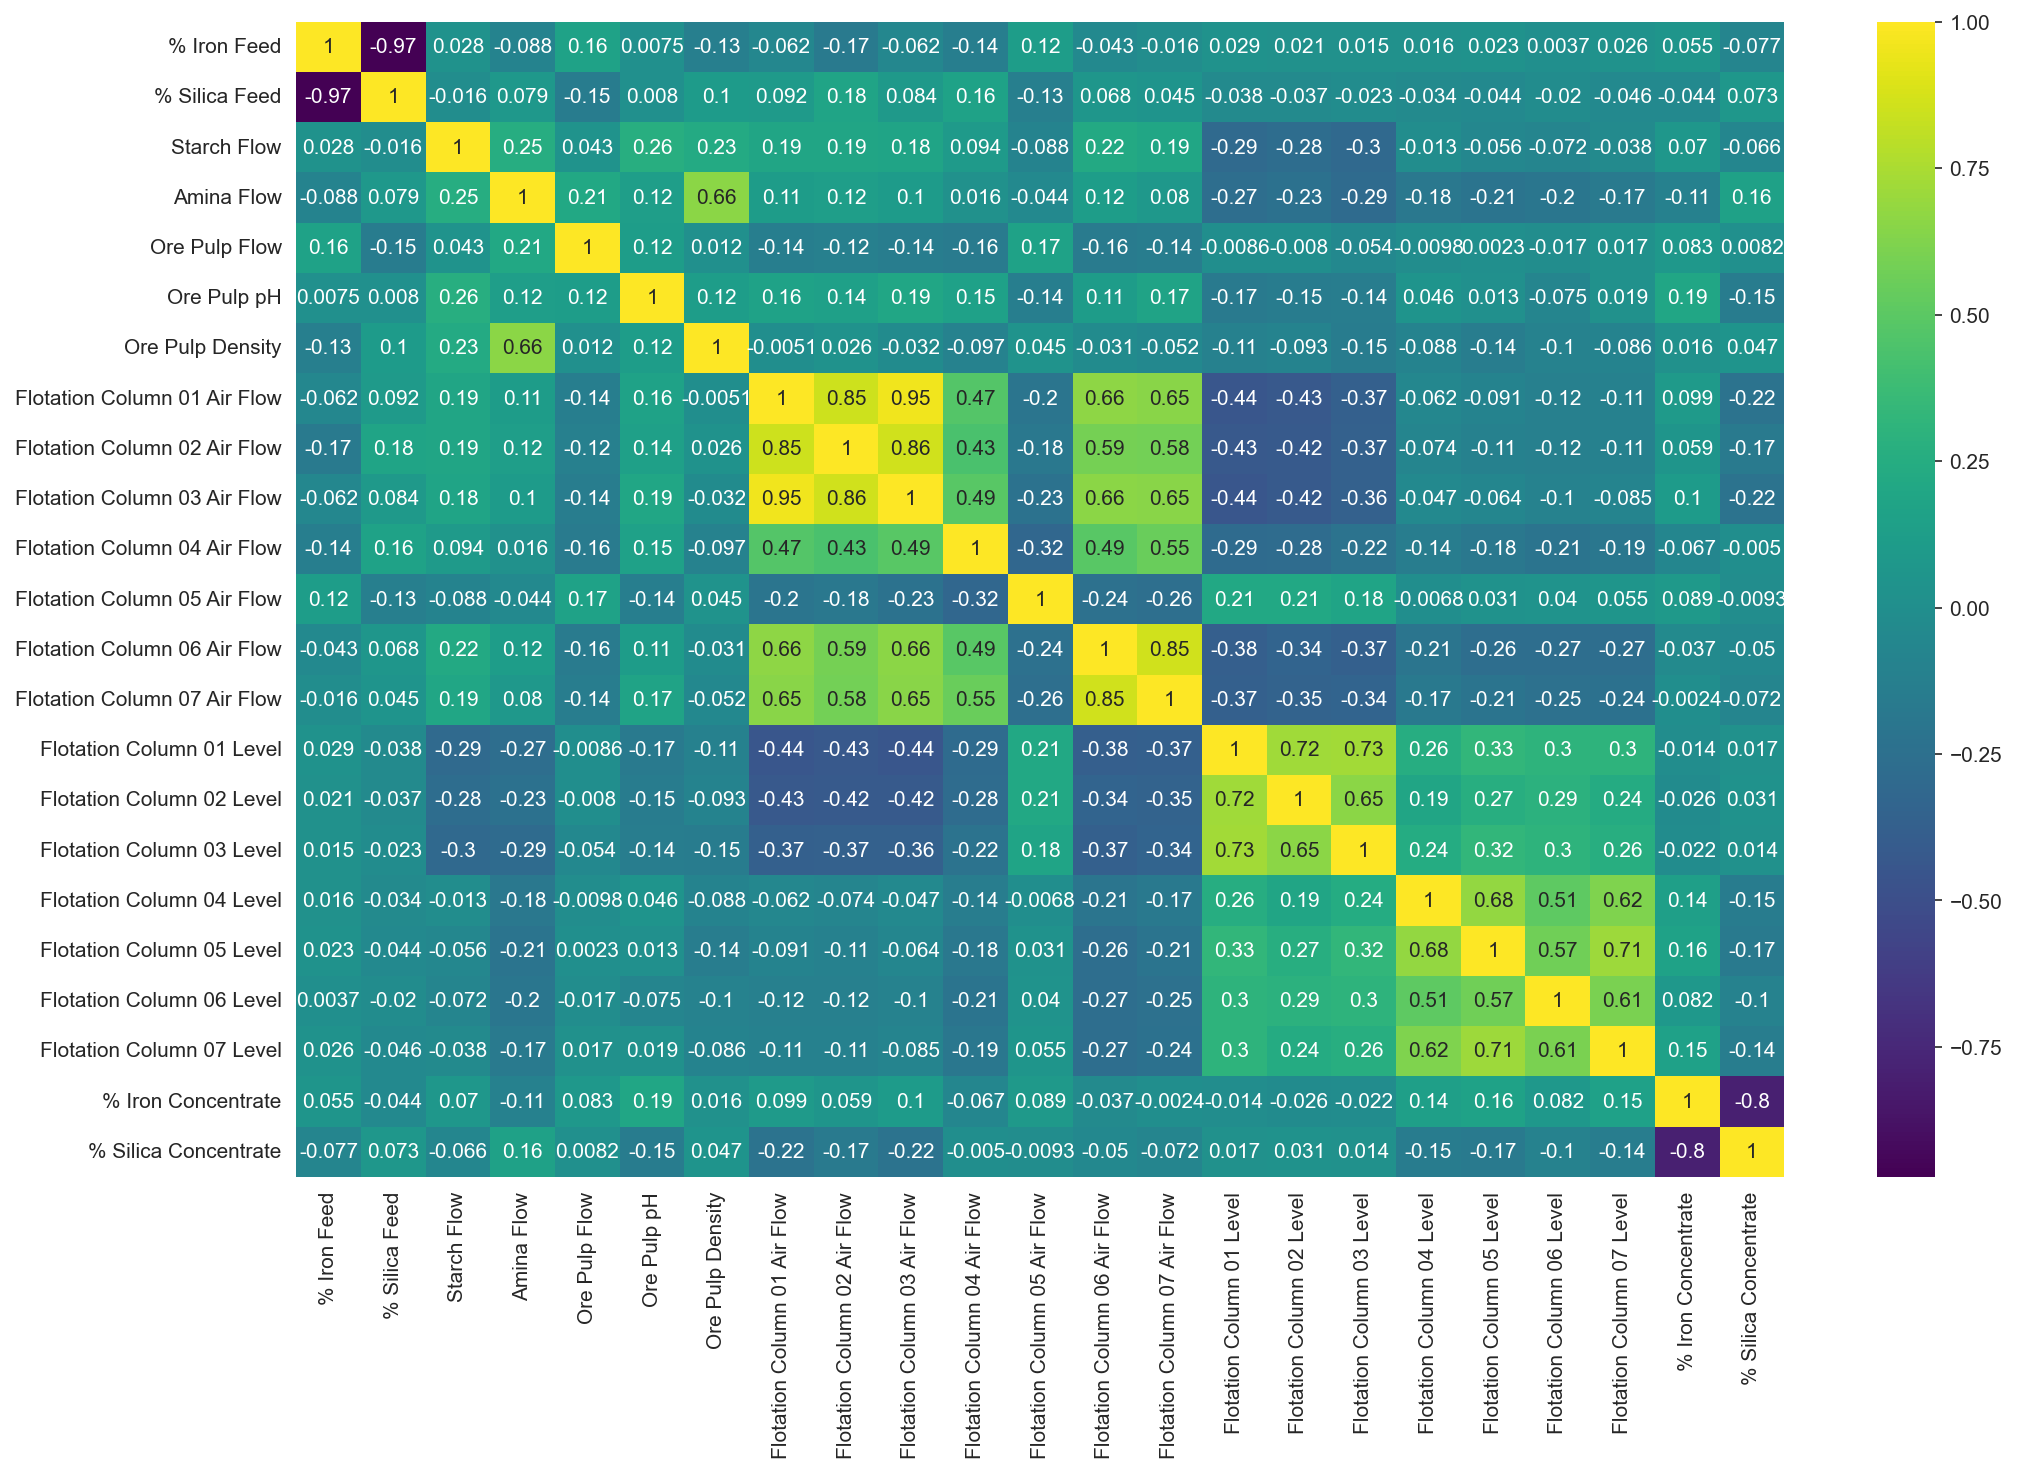

In [10]:
#Data Correlation
plt.figure(figsize=(16,10), dpi= 150)
sns.heatmap(data_cl.corr(), annot = True, cmap='viridis')
plt.show()

From Correlation Matrix, possible features relating with label are as follows:

iron concentrate

amina flow

ore pulp flow

ore pulp density

flotation air flow (01|02|03)

flotation column level (04|05|06|07)

% silica feed

<function matplotlib.pyplot.show(close=None, block=None)>

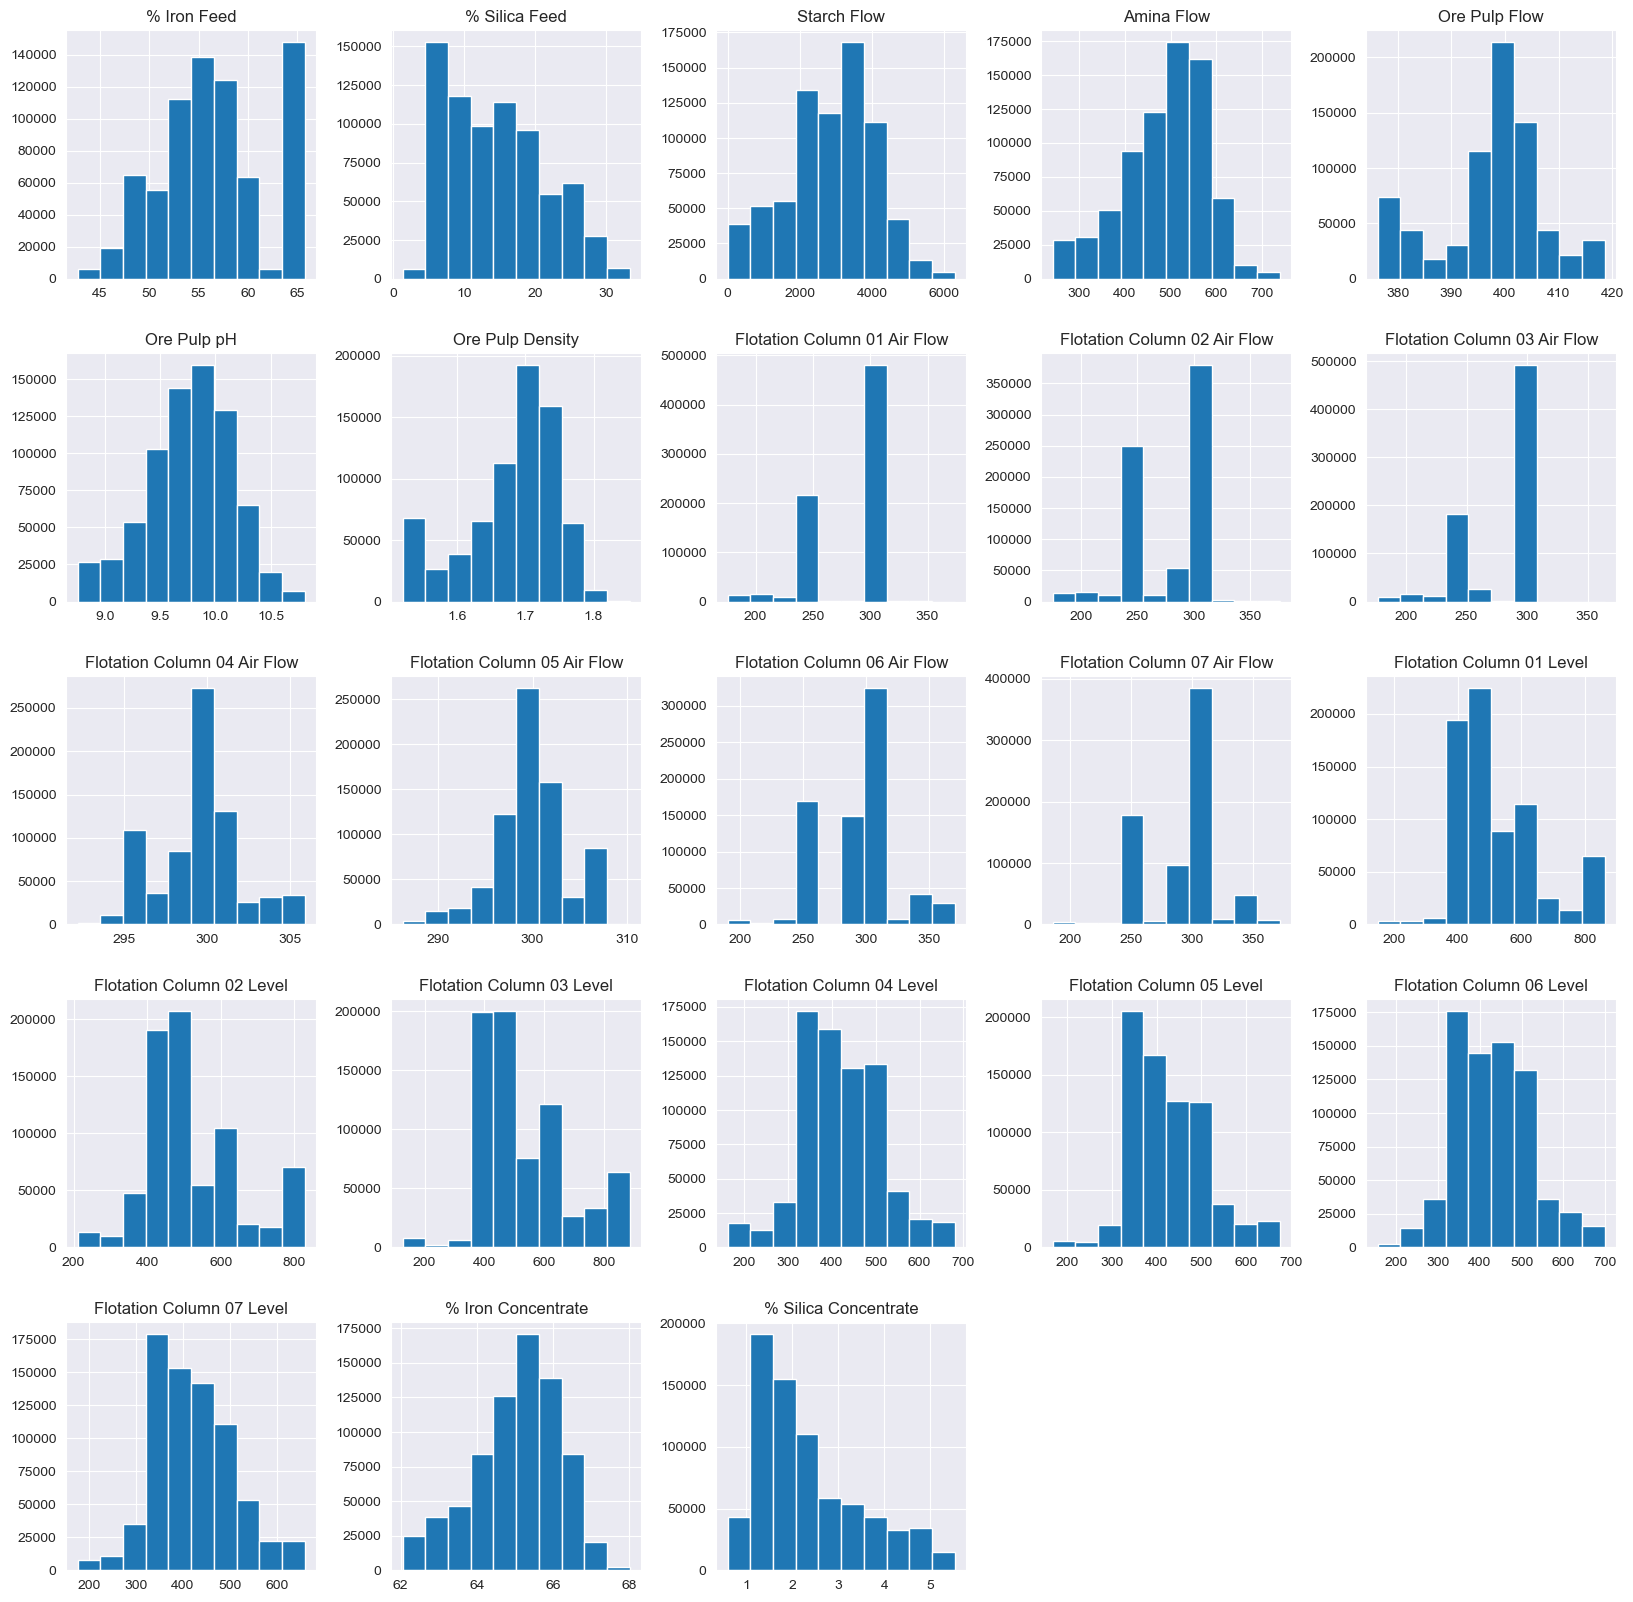

In [13]:
data_cl.hist(figsize=(20,20))
plt.show

In [14]:
data_cl.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

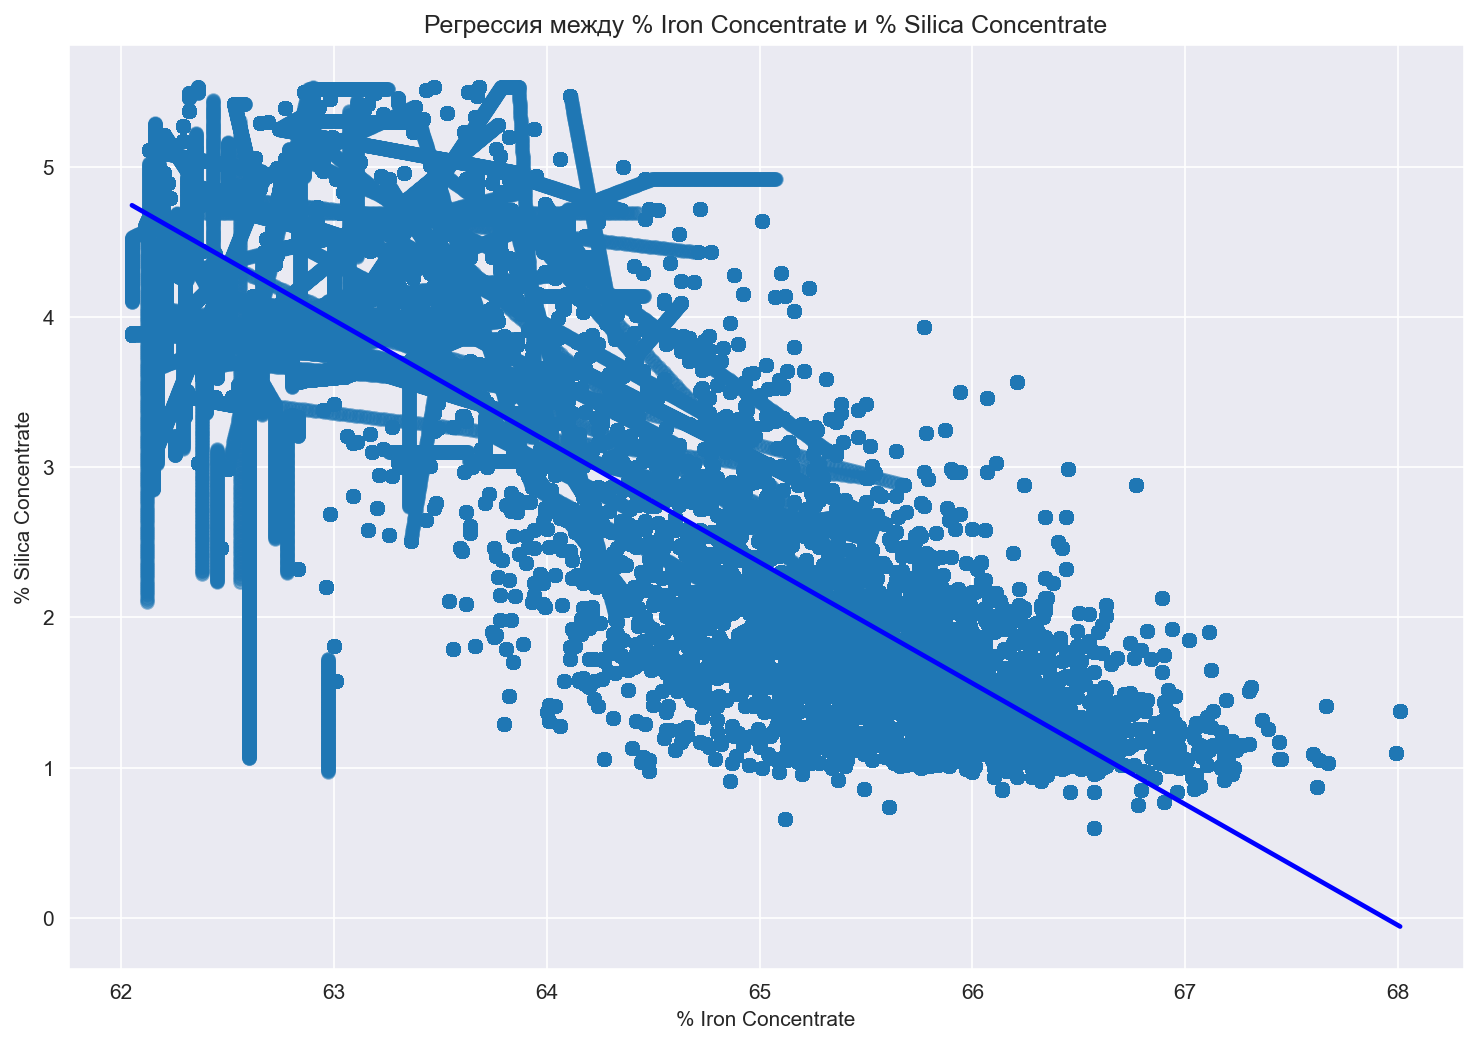

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8), dpi=150)
sns.regplot(
    x=data_cl['% Iron Concentrate'],
    y=data_cl['% Silica Concentrate'],
    scatter_kws={'alpha': 0.5},   # Уменьшенная прозрачность точек
    line_kws={'color': 'blue'}    # Цвет линии регрессии
)
plt.title('Регрессия между % Iron Concentrate и % Silica Concentrate')
plt.xlabel('% Iron Concentrate')
plt.ylabel('% Silica Concentrate')
plt.grid(True)
plt.show()


На графике показана отрицательная линейная зависимость между концентрацией железа (% Iron Concentrate) и концентрацией кремнезема (% Silica Concentrate). По мере увеличения концентрации железа, концентрация кремнезема, как правило, уменьшается, что подтверждается наклоном линии регрессии. Это может указывать на инверсную корреляцию между этими двумя показателями, что типично для процессов, где повышение чистоты одного элемента достигается за счет уменьшения другого.

Вывод:
Увеличение концентрации железа связано со снижением содержания кремнезема, что можно учитывать при управлении технологическим процессом, если целью является минимизация одного из компонентов.

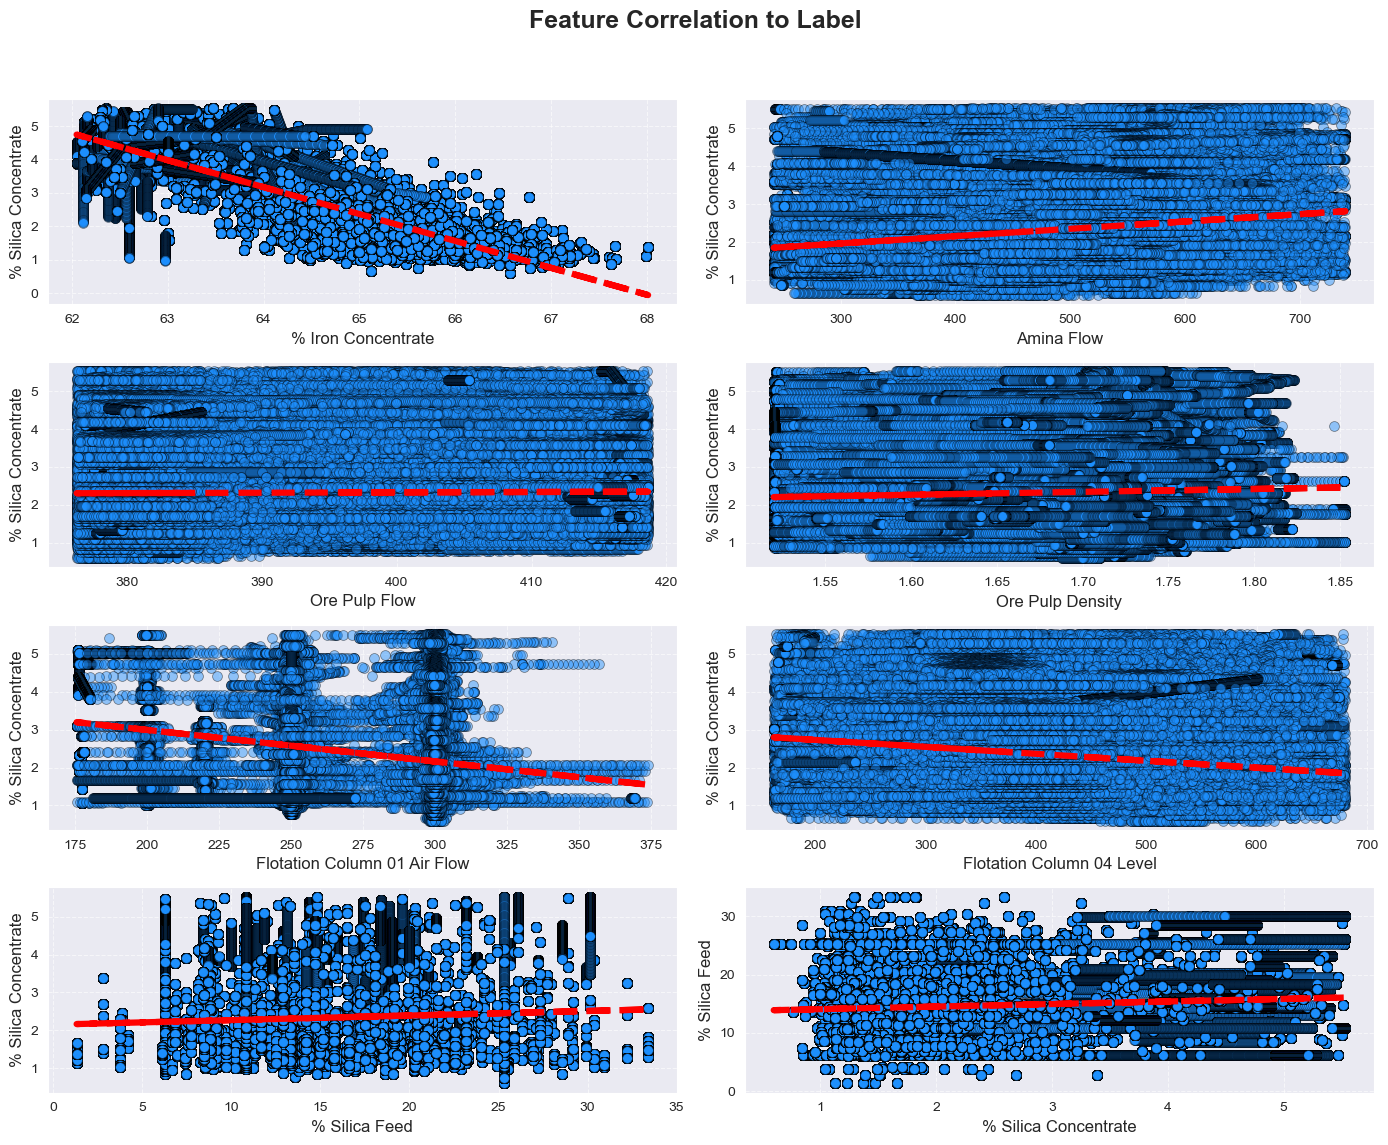

In [16]:
from scipy.stats import linregress  # импорт функции для выполнения линейной регрессии

# Создание подграфиков для отображения корреляции признаков с целевой переменной
fig, axs = plt.subplots(4, 2, figsize=(14, 12))  # создание 4x2 сетки подграфиков размером 14x12 дюймов
fig.suptitle('Feature Correlation to Label', fontsize=18, fontweight='bold')  # заголовок для всей фигуры

# Список пар (признак - целевая переменная) для визуализации
features = [
    ('% Iron Concentrate', '% Silica Concentrate'),  # железо против кремнезема
    ('Amina Flow', '% Silica Concentrate'),  # поток амина против кремнезема
    ('Ore Pulp Flow', '% Silica Concentrate'),  # поток руды против кремнезема
    ('Ore Pulp Density', '% Silica Concentrate'),  # плотность пульпы против кремнезема
    ('Flotation Column 01 Air Flow', '% Silica Concentrate'),  # поток воздуха в колонне 01 против кремнезема
    ('Flotation Column 04 Level', '% Silica Concentrate'),  # уровень в колонне 04 против кремнезема
    ('% Silica Feed', '% Silica Concentrate'),  # содержание кремнезема на входе против выхода
    ('% Silica Concentrate', '% Silica Feed')  # содержание кремнезема на выходе против входа
]

# Визуализация каждой пары признаков и целевой переменной
for i, (x_feature, y_feature) in enumerate(features):
    row, col = divmod(i, 2)  # определение строки и столбца для текущего подграфика
    ax = axs[row, col]  # выбор текущей оси для построения

    # Построение scatter plot для визуализации зависимости признака и целевой переменной
    sns.scatterplot(x=data_cl[x_feature], y=data_cl[y_feature], ax=ax,
                    color='dodgerblue', edgecolor='k', s=50, alpha=0.45)

    # Добавление линии тренда (линейная регрессия) на график
    slope, intercept, _, _, _ = linregress(data_cl[x_feature], data_cl[y_feature])  # выполнение линейной регрессии
    ax.plot(data_cl[x_feature], intercept + slope * data_cl[x_feature],
            color='red', linestyle='--', linewidth=4.5)  # построение линии регрессии

    # Настройка меток осей с размером шрифта
    ax.set_xlabel(x_feature, fontsize=12)  # метка для оси x
    ax.set_ylabel(y_feature, fontsize=12)  # метка для оси y
    ax.grid(True, linestyle='--', alpha=0.6)  # добавление сетки для улучшенной читаемости

# Настройка макета для улучшения отображения и добавление отступов
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # настройка отступов
plt.show()  # отображение графиков


На графиках показаны корреляции различных признаков с концентрацией кремнезема (% Silica Concentrate). Основные наблюдения:

% Iron Concentrate: Наблюдается сильная отрицательная корреляция — с увеличением концентрации железа содержание кремнезема снижается.

Amina Flow, Ore Pulp Flow, Ore Pulp Density, Flotation Column 01 Air Flow: Эти параметры практически не оказывают заметного влияния на концентрацию кремнезема (почти горизонтальные линии тренда).

Flotation Column 04 Level: Наблюдается слабая отрицательная корреляция с концентрацией кремнезема.

% Silica Feed: Отсутствует явная зависимость между подачей кремнезема и его концентрацией на выходе.

Вывод:
Концентрация железа имеет наибольшую отрицательную корреляцию с концентрацией кремнезема, остальные признаки имеют слабое или отсутствие значимого влияния.

Data exploration Conclusion

In [17]:
# Action1: Select only the possible features, drop other column

droplist=['% Iron Feed','Starch Flow',
          'Ore Pulp pH','Flotation Column 02 Air Flow',
          'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
          'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
          'Flotation Column 07 Air Flow', 'Flotation Column 04 Level',
          'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 05 Level',
          'Flotation Column 06 Level', 'Flotation Column 07 Level',]

data_cl=data_cl.drop(droplist,axis=1)
data_cl.shape

(737453, 8)

In [18]:
data_cl

,% Silica Feed,Amina Flow,Ore Pulp Flow,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 01 Level,% Iron Concentrate,% Silica Concentrate
0,16.98,557.434,395.713,1.74000,249.214,457.396,66.91,1.31
1,16.98,563.965,397.383,1.74000,249.719,451.891,66.91,1.31
2,16.98,568.054,399.668,1.74000,249.741,451.240,66.91,1.31
3,16.98,568.665,397.939,1.74000,249.917,452.441,66.91,1.31
4,16.98,558.167,400.254,1.74000,250.203,452.441,66.91,1.31
...,...,...,...,...,...,...,...,...
737448,23.20,441.052,386.570,1.65365,302.344,392.160,64.27,1.71
737449,23.20,473.436,384.939,1.65352,303.013,401.505,64.27,1.71
737450,23.20,500.488,383.496,1.65338,303.662,408.899,64.27,1.71
737451,23.20,491.548,384.976,1.65324,302.550,405.107,64.27,1.71


Training & Selection Regression Model

Linear Regression Model with Regularization Term (Lassso Model)

Linear Regression Model with Regularization Term (Ridge Model)

Random Forest Model

In [19]:
data_cl.columns

Index(['% Silica Feed', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 01 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [20]:
## Split data to training set and test set 
X=data_cl.drop('% Silica Concentrate',axis=1)

y=data_cl['% Silica Concentrate']#выбор целевой переменной

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)#разбиение на тестовую и тренировучную выборку


In [21]:
# normalize the training data 
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [39]:
# Обновленная функция objective с использованием lightgbm.train() и GPU
def objective(trial):
    # Задание гиперпараметров модели LightGBM, которые будут оптимизироваться Optuna
    param = {
        'objective': 'regression',  # Задача регрессии, так как предсказываем непрерывные значения
        'metric': 'rmse',  # Метрика для оценки модели - RMSE (Root Mean Squared Error)
        'verbosity': -1,  # Отключение детализированного вывода
        'boosting_type': 'gbdt',  # Тип бустинга - градиентный бустинг (Gradient Boosting Decision Trees)
        'device': 'gpu',  # Используем GPU для ускорения обучения
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),  # Коэффициент обучения, который определяет размер шага обновления весов
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),  # Максимальное количество листьев в каждом дереве, что регулирует его сложность
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Максимальная глубина деревьев для контроля сложности модели
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Минимальное количество образцов в каждом листе для борьбы с переобучением
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e1, log=True),  # Минимальный вес образцов в каждом листе
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),  # Доля случайных подвыборок данных для каждой итерации
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  # Доля признаков, используемых для создания каждого дерева
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e1, log=True),  # L1-регуляризация для уменьшения переобучения
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e1, log=True)  # L2-регуляризация для борьбы с переобучением
    }
    # Создание объектов Dataset для LightGBM
    train_data = lgb.Dataset(X_train_norm, label=y_train)  # Данные для обучения
    valid_data = lgb.Dataset(X_test_norm, label=y_test, reference=train_data)  # Данные для валидации с ссылкой на обучающую выборку
    # Обучение модели с использованием lightgbm.train() и GPU
    model = lgb.train(
        param,  # Гиперпараметры, которые будут использоваться для модели
        train_data,  # Данные для обучения
        num_boost_round=7000,  # Максимальное количество итераций (деревьев)
        valid_sets=[valid_data],  # Данные для валидации
        callbacks=[  # Колбэки для управления процессом обучения
            lgb.early_stopping(stopping_rounds=300),  # Остановка обучения, если метрика не улучшается в течение 300 итераций
            lgb.log_evaluation(period=100)  # Логирование метрики каждые 100 итераций
        ]
    )
    # Предсказание и вычисление RMSE на тестовых данных
    preds = model.predict(X_test_norm, num_iteration=model.best_iteration)  # Предсказание с использованием лучшей итерации
    rmse = mean_squared_error(y_test, preds, squared=False)  # Вычисление RMSE как целевой метрики для оптимизации
    return rmse  # Возврат значения RMSE, которое Optuna будет минимизировать

In [40]:
# Функция для отслеживания прогресса каждого испытания
def print_progress(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")
    print(f"Best trial so far: Trial {study.best_trial.number} with value: {study.best_trial.value}")

# Инициализация исследования и оптимизация гиперпараметров с отслеживанием прогресса
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, callbacks=[print_progress])

[I 2024-10-29 23:51:21,268] A new study created in memory with name: no-name-50896d31-4ce6-4476-976f-4b8409c1cdaf


Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 1.07454
[200]	valid_0's rmse: 1.02339
[300]	valid_0's rmse: 0.976748
[400]	valid_0's rmse: 0.934429
[500]	valid_0's rmse: 0.89348
[600]	valid_0's rmse: 0.854295
[700]	valid_0's rmse: 0.824668
[800]	valid_0's rmse: 0.795721
[900]	valid_0's rmse: 0.767446
[1000]	valid_0's rmse: 0.74168
[1100]	valid_0's rmse: 0.716325
[1200]	valid_0's rmse: 0.691595
[1300]	valid_0's rmse: 0.670553
[1400]	valid_0's rmse: 0.649938
[1500]	valid_0's rmse: 0.632887
[1600]	valid_0's rmse: 0.61486
[1700]	valid_0's rmse: 0.599986
[1800]	valid_0's rmse: 0.585073
[1900]	valid_0's rmse: 0.572062
[2000]	valid_0's rmse: 0.559806
[2100]	valid_0's rmse: 0.548988
[2200]	valid_0's rmse: 0.540672
[2300]	valid_0's rmse: 0.530796
[2400]	valid_0's rmse: 0.521943
[2500]	valid_0's rmse: 0.51405
[2600]	valid_0's rmse: 0.507299
[2700]	valid_0's rmse: 0.500115
[2800]	valid_0's rmse: 0.492942
[2900]	valid_0's rmse: 0.486932
[3000]	valid_0's rmse: 0.

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-29 23:57:36,112] Trial 0 finished with value: 0.3903277861725565 and parameters: {'learning_rate': 0.0009778929822427205, 'num_leaves': 161, 'max_depth': 7, 'min_child_samples': 73, 'min_child_weight': 0.3042102410824793, 'subsample': 0.8347623596865437, 'feature_fraction': 0.5335038897410942, 'reg_alpha': 4.327353351770465, 'reg_lambda': 0.10024860101351142}. Best is trial 0 with value: 0.3903277861725565.


Trial 0 finished with value: 0.3903277861725565 and parameters: {'learning_rate': 0.0009778929822427205, 'num_leaves': 161, 'max_depth': 7, 'min_child_samples': 73, 'min_child_weight': 0.3042102410824793, 'subsample': 0.8347623596865437, 'feature_fraction': 0.5335038897410942, 'reg_alpha': 4.327353351770465, 'reg_lambda': 0.10024860101351142}
Best trial so far: Trial 0 with value: 0.3903277861725565
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 1.0023
[200]	valid_0's rmse: 0.90357
[300]	valid_0's rmse: 0.81727
[400]	valid_0's rmse: 0.743544
[500]	valid_0's rmse: 0.682767
[600]	valid_0's rmse: 0.633388
[700]	valid_0's rmse: 0.590765
[800]	valid_0's rmse: 0.555993
[900]	valid_0's rmse: 0.52628
[1000]	valid_0's rmse: 0.50143
[1100]	valid_0's rmse: 0.479954
[1200]	valid_0's rmse: 0.461735
[1300]	valid_0's rmse: 0.446343
[1400]	valid_0's rmse: 0.433057
[1500]	valid_0's rmse: 0.421699
[1600]	valid_0's rmse: 0.411828
[1700]	valid_0's rmse: 0.403095
[1800]

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:08:18,440] Trial 1 finished with value: 0.2922510382540998 and parameters: {'learning_rate': 0.0016111211323058092, 'num_leaves': 185, 'max_depth': 8, 'min_child_samples': 80, 'min_child_weight': 0.013686028944960503, 'subsample': 0.7219757830425741, 'feature_fraction': 0.8809167072211541, 'reg_alpha': 0.11427343819029531, 'reg_lambda': 0.0005553727363154339}. Best is trial 1 with value: 0.2922510382540998.


Trial 1 finished with value: 0.2922510382540998 and parameters: {'learning_rate': 0.0016111211323058092, 'num_leaves': 185, 'max_depth': 8, 'min_child_samples': 80, 'min_child_weight': 0.013686028944960503, 'subsample': 0.7219757830425741, 'feature_fraction': 0.8809167072211541, 'reg_alpha': 0.11427343819029531, 'reg_lambda': 0.0005553727363154339}
Best trial so far: Trial 1 with value: 0.2922510382540998
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.46714
[200]	valid_0's rmse: 0.378973
[300]	valid_0's rmse: 0.343581
[400]	valid_0's rmse: 0.325654
[500]	valid_0's rmse: 0.310134
[600]	valid_0's rmse: 0.298362
[700]	valid_0's rmse: 0.28572
[800]	valid_0's rmse: 0.273721
[900]	valid_0's rmse: 0.261478
[1000]	valid_0's rmse: 0.251405
[1100]	valid_0's rmse: 0.242314
[1200]	valid_0's rmse: 0.232255
[1300]	valid_0's rmse: 0.224411
[1400]	valid_0's rmse: 0.217192
[1500]	valid_0's rmse: 0.209332
[1600]	valid_0's rmse: 0.202568
[1700]	valid_0's rmse: 0.195

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:17:33,448] Trial 2 finished with value: 0.10010967369282779 and parameters: {'learning_rate': 0.019428442274712097, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 38, 'min_child_weight': 0.050920158556793556, 'subsample': 0.6373537196778759, 'feature_fraction': 0.9727729753573554, 'reg_alpha': 0.0011703859208842349, 'reg_lambda': 0.0010721181738103506}. Best is trial 2 with value: 0.10010967369282779.


Trial 2 finished with value: 0.10010967369282779 and parameters: {'learning_rate': 0.019428442274712097, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 38, 'min_child_weight': 0.050920158556793556, 'subsample': 0.6373537196778759, 'feature_fraction': 0.9727729753573554, 'reg_alpha': 0.0011703859208842349, 'reg_lambda': 0.0010721181738103506}
Best trial so far: Trial 2 with value: 0.10010967369282779
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.418908
[200]	valid_0's rmse: 0.367732
[300]	valid_0's rmse: 0.337464
[400]	valid_0's rmse: 0.312339
[500]	valid_0's rmse: 0.291613
[600]	valid_0's rmse: 0.270994
[700]	valid_0's rmse: 0.254841
[800]	valid_0's rmse: 0.23829
[900]	valid_0's rmse: 0.224153
[1000]	valid_0's rmse: 0.212835
[1100]	valid_0's rmse: 0.203074
[1200]	valid_0's rmse: 0.193755
[1300]	valid_0's rmse: 0.185566
[1400]	valid_0's rmse: 0.179038
[1500]	valid_0's rmse: 0.172795
[1600]	valid_0's rmse: 0.168019
[1700]	valid_0's rmse: 0

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:22:45,630] Trial 3 finished with value: 0.09625117916022727 and parameters: {'learning_rate': 0.047767094293375126, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 49, 'min_child_weight': 0.001352270395268274, 'subsample': 0.45524470695353747, 'feature_fraction': 0.9455583445841685, 'reg_alpha': 3.6312154276292037, 'reg_lambda': 0.00017445350040346262}. Best is trial 3 with value: 0.09625117916022727.


Trial 3 finished with value: 0.09625117916022727 and parameters: {'learning_rate': 0.047767094293375126, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 49, 'min_child_weight': 0.001352270395268274, 'subsample': 0.45524470695353747, 'feature_fraction': 0.9455583445841685, 'reg_alpha': 3.6312154276292037, 'reg_lambda': 0.00017445350040346262}
Best trial so far: Trial 3 with value: 0.09625117916022727
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 1.11429
[200]	valid_0's rmse: 1.10527
[300]	valid_0's rmse: 1.09616
[400]	valid_0's rmse: 1.0871
[500]	valid_0's rmse: 1.07866
[600]	valid_0's rmse: 1.06996
[700]	valid_0's rmse: 1.06132
[800]	valid_0's rmse: 1.05387
[900]	valid_0's rmse: 1.04573
[1000]	valid_0's rmse: 1.03796
[1100]	valid_0's rmse: 1.03003
[1200]	valid_0's rmse: 1.02153
[1300]	valid_0's rmse: 1.01393
[1400]	valid_0's rmse: 1.00612
[1500]	valid_0's rmse: 0.998807
[1600]	valid_0's rmse: 0.991023
[1700]	valid_0's rmse: 0.983751
[1800]	v

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:24:00,679] Trial 4 finished with value: 0.7273205198524583 and parameters: {'learning_rate': 0.00016424110115247794, 'num_leaves': 210, 'max_depth': 3, 'min_child_samples': 36, 'min_child_weight': 0.0042845637821395215, 'subsample': 0.897753693807233, 'feature_fraction': 0.7298158940506629, 'reg_alpha': 3.808956998717885, 'reg_lambda': 0.004515847695853191}. Best is trial 3 with value: 0.09625117916022727.


Trial 4 finished with value: 0.7273205198524583 and parameters: {'learning_rate': 0.00016424110115247794, 'num_leaves': 210, 'max_depth': 3, 'min_child_samples': 36, 'min_child_weight': 0.0042845637821395215, 'subsample': 0.897753693807233, 'feature_fraction': 0.7298158940506629, 'reg_alpha': 3.808956998717885, 'reg_lambda': 0.004515847695853191}
Best trial so far: Trial 3 with value: 0.09625117916022727
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.434982
[200]	valid_0's rmse: 0.359571
[300]	valid_0's rmse: 0.324138
[400]	valid_0's rmse: 0.301957
[500]	valid_0's rmse: 0.285157
[600]	valid_0's rmse: 0.269008
[700]	valid_0's rmse: 0.252928
[800]	valid_0's rmse: 0.239443
[900]	valid_0's rmse: 0.227987
[1000]	valid_0's rmse: 0.217788
[1100]	valid_0's rmse: 0.208434
[1200]	valid_0's rmse: 0.200484
[1300]	valid_0's rmse: 0.193375
[1400]	valid_0's rmse: 0.185902
[1500]	valid_0's rmse: 0.179719
[1600]	valid_0's rmse: 0.174347
[1700]	valid_0's rmse: 0.16

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:31:29,493] Trial 5 finished with value: 0.09320046322775137 and parameters: {'learning_rate': 0.026378153650151632, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 53, 'min_child_weight': 0.047763685847148074, 'subsample': 0.7377947570383006, 'feature_fraction': 0.8484079670580875, 'reg_alpha': 0.21272249613905436, 'reg_lambda': 0.01737854106345705}. Best is trial 5 with value: 0.09320046322775137.


Trial 5 finished with value: 0.09320046322775137 and parameters: {'learning_rate': 0.026378153650151632, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 53, 'min_child_weight': 0.047763685847148074, 'subsample': 0.7377947570383006, 'feature_fraction': 0.8484079670580875, 'reg_alpha': 0.21272249613905436, 'reg_lambda': 0.01737854106345705}
Best trial so far: Trial 5 with value: 0.09320046322775137
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.615792
[200]	valid_0's rmse: 0.480449
[300]	valid_0's rmse: 0.434847
[400]	valid_0's rmse: 0.411453
[500]	valid_0's rmse: 0.392134
[600]	valid_0's rmse: 0.381669
[700]	valid_0's rmse: 0.372329
[800]	valid_0's rmse: 0.364064
[900]	valid_0's rmse: 0.356498
[1000]	valid_0's rmse: 0.35004
[1100]	valid_0's rmse: 0.341362
[1200]	valid_0's rmse: 0.335659
[1300]	valid_0's rmse: 0.330343
[1400]	valid_0's rmse: 0.324825
[1500]	valid_0's rmse: 0.320156
[1600]	valid_0's rmse: 0.313198
[1700]	valid_0's rmse: 0.307

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:38:19,574] Trial 6 finished with value: 0.16373458531118137 and parameters: {'learning_rate': 0.010467884583769514, 'num_leaves': 205, 'max_depth': 7, 'min_child_samples': 89, 'min_child_weight': 0.36161870277981034, 'subsample': 0.8569772171434191, 'feature_fraction': 0.9372951188162175, 'reg_alpha': 0.0021859153447752336, 'reg_lambda': 0.04835214954398468}. Best is trial 5 with value: 0.09320046322775137.


Trial 6 finished with value: 0.16373458531118137 and parameters: {'learning_rate': 0.010467884583769514, 'num_leaves': 205, 'max_depth': 7, 'min_child_samples': 89, 'min_child_weight': 0.36161870277981034, 'subsample': 0.8569772171434191, 'feature_fraction': 0.9372951188162175, 'reg_alpha': 0.0021859153447752336, 'reg_lambda': 0.04835214954398468}
Best trial so far: Trial 5 with value: 0.09320046322775137
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 1.07667
[200]	valid_0's rmse: 1.03529
[300]	valid_0's rmse: 0.996036
[400]	valid_0's rmse: 0.959161
[500]	valid_0's rmse: 0.92657
[600]	valid_0's rmse: 0.894884
[700]	valid_0's rmse: 0.865294
[800]	valid_0's rmse: 0.840761
[900]	valid_0's rmse: 0.815864
[1000]	valid_0's rmse: 0.793381
[1100]	valid_0's rmse: 0.772024
[1200]	valid_0's rmse: 0.750763
[1300]	valid_0's rmse: 0.732804
[1400]	valid_0's rmse: 0.715598
[1500]	valid_0's rmse: 0.700314
[1600]	valid_0's rmse: 0.685245
[1700]	valid_0's rmse: 0.6719

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:40:29,457] Trial 7 finished with value: 0.4856819420069027 and parameters: {'learning_rate': 0.0007499544434734567, 'num_leaves': 22, 'max_depth': 15, 'min_child_samples': 29, 'min_child_weight': 0.9480032011679995, 'subsample': 0.8146599200847773, 'feature_fraction': 0.7521538960858987, 'reg_alpha': 8.418751486990308, 'reg_lambda': 0.0010052187729226885}. Best is trial 5 with value: 0.09320046322775137.


Trial 7 finished with value: 0.4856819420069027 and parameters: {'learning_rate': 0.0007499544434734567, 'num_leaves': 22, 'max_depth': 15, 'min_child_samples': 29, 'min_child_weight': 0.9480032011679995, 'subsample': 0.8146599200847773, 'feature_fraction': 0.7521538960858987, 'reg_alpha': 8.418751486990308, 'reg_lambda': 0.0010052187729226885}
Best trial so far: Trial 5 with value: 0.09320046322775137
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.653454
[200]	valid_0's rmse: 0.466502
[300]	valid_0's rmse: 0.381362
[400]	valid_0's rmse: 0.336856
[500]	valid_0's rmse: 0.308356
[600]	valid_0's rmse: 0.288523
[700]	valid_0's rmse: 0.27209
[800]	valid_0's rmse: 0.259572
[900]	valid_0's rmse: 0.249101
[1000]	valid_0's rmse: 0.24036
[1100]	valid_0's rmse: 0.233813
[1200]	valid_0's rmse: 0.227159
[1300]	valid_0's rmse: 0.221203
[1400]	valid_0's rmse: 0.215837
[1500]	valid_0's rmse: 0.210183
[1600]	valid_0's rmse: 0.205251
[1700]	valid_0's rmse: 0.19994


C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 00:54:37,686] Trial 8 finished with value: 0.10990365751174284 and parameters: {'learning_rate': 0.008269416952783337, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 79, 'min_child_weight': 2.2985331347344826, 'subsample': 0.5122756937395402, 'feature_fraction': 0.819735891587404, 'reg_alpha': 0.030279498608319723, 'reg_lambda': 0.0007838150898972117}. Best is trial 5 with value: 0.09320046322775137.


Trial 8 finished with value: 0.10990365751174284 and parameters: {'learning_rate': 0.008269416952783337, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 79, 'min_child_weight': 2.2985331347344826, 'subsample': 0.5122756937395402, 'feature_fraction': 0.819735891587404, 'reg_alpha': 0.030279498608319723, 'reg_lambda': 0.0007838150898972117}
Best trial so far: Trial 5 with value: 0.09320046322775137
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.396767
[200]	valid_0's rmse: 0.349461
[300]	valid_0's rmse: 0.320906
[400]	valid_0's rmse: 0.297986
[500]	valid_0's rmse: 0.277569
[600]	valid_0's rmse: 0.258432
[700]	valid_0's rmse: 0.243372
[800]	valid_0's rmse: 0.232195
[900]	valid_0's rmse: 0.219449
[1000]	valid_0's rmse: 0.209381
[1100]	valid_0's rmse: 0.198465
[1200]	valid_0's rmse: 0.190682
[1300]	valid_0's rmse: 0.183323
[1400]	valid_0's rmse: 0.177218
[1500]	valid_0's rmse: 0.171488
[1600]	valid_0's rmse: 0.165713
[1700]	valid_0's rmse: 0.1

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 01:02:22,657] Trial 9 finished with value: 0.0949588475748249 and parameters: {'learning_rate': 0.04909484219596669, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 38, 'min_child_weight': 5.908802167713368, 'subsample': 0.4395250958669753, 'feature_fraction': 0.7309283084670066, 'reg_alpha': 0.02539136357527673, 'reg_lambda': 0.07813508173393593}. Best is trial 5 with value: 0.09320046322775137.


Trial 9 finished with value: 0.0949588475748249 and parameters: {'learning_rate': 0.04909484219596669, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 38, 'min_child_weight': 5.908802167713368, 'subsample': 0.4395250958669753, 'feature_fraction': 0.7309283084670066, 'reg_alpha': 0.02539136357527673, 'reg_lambda': 0.07813508173393593}
Best trial so far: Trial 5 with value: 0.09320046322775137
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.23877
[200]	valid_0's rmse: 0.183397
[300]	valid_0's rmse: 0.158847
[400]	valid_0's rmse: 0.141686
[500]	valid_0's rmse: 0.130114
[600]	valid_0's rmse: 0.122775
[700]	valid_0's rmse: 0.117322
[800]	valid_0's rmse: 0.112608
[900]	valid_0's rmse: 0.108926
[1000]	valid_0's rmse: 0.105971
[1100]	valid_0's rmse: 0.103493
[1200]	valid_0's rmse: 0.101232
[1300]	valid_0's rmse: 0.0995163
[1400]	valid_0's rmse: 0.0980786
[1500]	valid_0's rmse: 0.0966851
[1600]	valid_0's rmse: 0.09523
[1700]	valid_0's rmse: 0.093804

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 01:23:31,385] Trial 10 finished with value: 0.07946807068282989 and parameters: {'learning_rate': 0.0943608178836945, 'num_leaves': 292, 'max_depth': 11, 'min_child_samples': 11, 'min_child_weight': 0.04343058718049279, 'subsample': 0.9882244089053711, 'feature_fraction': 0.5943483153900851, 'reg_alpha': 0.3082399741062748, 'reg_lambda': 5.902271098715065}. Best is trial 10 with value: 0.07946807068282989.


Trial 10 finished with value: 0.07946807068282989 and parameters: {'learning_rate': 0.0943608178836945, 'num_leaves': 292, 'max_depth': 11, 'min_child_samples': 11, 'min_child_weight': 0.04343058718049279, 'subsample': 0.9882244089053711, 'feature_fraction': 0.5943483153900851, 'reg_alpha': 0.3082399741062748, 'reg_lambda': 5.902271098715065}
Best trial so far: Trial 10 with value: 0.07946807068282989
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.265663
[200]	valid_0's rmse: 0.201108
[300]	valid_0's rmse: 0.172528
[400]	valid_0's rmse: 0.154776
[500]	valid_0's rmse: 0.140903
[600]	valid_0's rmse: 0.131438
[700]	valid_0's rmse: 0.12546
[800]	valid_0's rmse: 0.120378
[900]	valid_0's rmse: 0.115983
[1000]	valid_0's rmse: 0.112557
[1100]	valid_0's rmse: 0.109329
[1200]	valid_0's rmse: 0.106482
[1300]	valid_0's rmse: 0.103837
[1400]	valid_0's rmse: 0.102025
[1500]	valid_0's rmse: 0.100429
[1600]	valid_0's rmse: 0.0986629
[1700]	valid_0's rmse: 0.09724

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 01:43:11,850] Trial 11 finished with value: 0.07905044309968881 and parameters: {'learning_rate': 0.07534358133023443, 'num_leaves': 274, 'max_depth': 11, 'min_child_samples': 9, 'min_child_weight': 0.04235063468773948, 'subsample': 0.9763813354547902, 'feature_fraction': 0.5610214907665589, 'reg_alpha': 0.3453489913802392, 'reg_lambda': 5.1414393564689265}. Best is trial 11 with value: 0.07905044309968881.


Trial 11 finished with value: 0.07905044309968881 and parameters: {'learning_rate': 0.07534358133023443, 'num_leaves': 274, 'max_depth': 11, 'min_child_samples': 9, 'min_child_weight': 0.04235063468773948, 'subsample': 0.9763813354547902, 'feature_fraction': 0.5610214907665589, 'reg_alpha': 0.3453489913802392, 'reg_lambda': 5.1414393564689265}
Best trial so far: Trial 11 with value: 0.07905044309968881
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.234927
[200]	valid_0's rmse: 0.1799
[300]	valid_0's rmse: 0.156488
[400]	valid_0's rmse: 0.14005
[500]	valid_0's rmse: 0.129425
[600]	valid_0's rmse: 0.121703
[700]	valid_0's rmse: 0.116512
[800]	valid_0's rmse: 0.11233
[900]	valid_0's rmse: 0.108598
[1000]	valid_0's rmse: 0.105524
[1100]	valid_0's rmse: 0.103227
[1200]	valid_0's rmse: 0.101243
[1300]	valid_0's rmse: 0.0991281
[1400]	valid_0's rmse: 0.097393
[1500]	valid_0's rmse: 0.0961171
[1600]	valid_0's rmse: 0.0945116
[1700]	valid_0's rmse: 0.09351

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 02:05:16,351] Trial 12 finished with value: 0.07898798219715367 and parameters: {'learning_rate': 0.09725631763340743, 'num_leaves': 296, 'max_depth': 11, 'min_child_samples': 5, 'min_child_weight': 0.015018701621054224, 'subsample': 0.9983599868204935, 'feature_fraction': 0.5434767007257829, 'reg_alpha': 0.402145663841348, 'reg_lambda': 9.246045355519525}. Best is trial 12 with value: 0.07898798219715367.


Trial 12 finished with value: 0.07898798219715367 and parameters: {'learning_rate': 0.09725631763340743, 'num_leaves': 296, 'max_depth': 11, 'min_child_samples': 5, 'min_child_weight': 0.015018701621054224, 'subsample': 0.9983599868204935, 'feature_fraction': 0.5434767007257829, 'reg_alpha': 0.402145663841348, 'reg_lambda': 9.246045355519525}
Best trial so far: Trial 12 with value: 0.07898798219715367
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.28582
[200]	valid_0's rmse: 0.221741
[300]	valid_0's rmse: 0.192913
[400]	valid_0's rmse: 0.173766
[500]	valid_0's rmse: 0.161769
[600]	valid_0's rmse: 0.15271
[700]	valid_0's rmse: 0.145449
[800]	valid_0's rmse: 0.140088
[900]	valid_0's rmse: 0.135726
[1000]	valid_0's rmse: 0.13197
[1100]	valid_0's rmse: 0.128706
[1200]	valid_0's rmse: 0.126274
[1300]	valid_0's rmse: 0.123564
[1400]	valid_0's rmse: 0.121099
[1500]	valid_0's rmse: 0.119617
[1600]	valid_0's rmse: 0.117734
[1700]	valid_0's rmse: 0.116231
[

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 02:24:23,760] Trial 13 finished with value: 0.09476965236649296 and parameters: {'learning_rate': 0.09809152210049905, 'num_leaves': 269, 'max_depth': 11, 'min_child_samples': 6, 'min_child_weight': 0.00962004952115349, 'subsample': 0.9996787641776239, 'feature_fraction': 0.40171161925286264, 'reg_alpha': 0.00010141315708980301, 'reg_lambda': 7.973413973569311}. Best is trial 12 with value: 0.07898798219715367.


Trial 13 finished with value: 0.09476965236649296 and parameters: {'learning_rate': 0.09809152210049905, 'num_leaves': 269, 'max_depth': 11, 'min_child_samples': 6, 'min_child_weight': 0.00962004952115349, 'subsample': 0.9996787641776239, 'feature_fraction': 0.40171161925286264, 'reg_alpha': 0.00010141315708980301, 'reg_lambda': 7.973413973569311}
Best trial so far: Trial 12 with value: 0.07898798219715367
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.933712
[200]	valid_0's rmse: 0.777847
[300]	valid_0's rmse: 0.663015
[400]	valid_0's rmse: 0.577258
[500]	valid_0's rmse: 0.509747
[600]	valid_0's rmse: 0.457886
[700]	valid_0's rmse: 0.42387
[800]	valid_0's rmse: 0.396308
[900]	valid_0's rmse: 0.373179
[1000]	valid_0's rmse: 0.354273
[1100]	valid_0's rmse: 0.338101
[1200]	valid_0's rmse: 0.323994
[1300]	valid_0's rmse: 0.312383
[1400]	valid_0's rmse: 0.301653
[1500]	valid_0's rmse: 0.293024
[1600]	valid_0's rmse: 0.284738
[1700]	valid_0's rmse: 0.2

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-30 02:46:02,562] Trial 14 finished with value: 0.15682603721082972 and parameters: {'learning_rate': 0.003393816868224628, 'num_leaves': 256, 'max_depth': 13, 'min_child_samples': 17, 'min_child_weight': 0.19216826734536566, 'subsample': 0.9387981967633663, 'feature_fraction': 0.607609042367955, 'reg_alpha': 0.7320259631196296, 'reg_lambda': 1.0533443089022947}. Best is trial 12 with value: 0.07898798219715367.


Trial 14 finished with value: 0.15682603721082972 and parameters: {'learning_rate': 0.003393816868224628, 'num_leaves': 256, 'max_depth': 13, 'min_child_samples': 17, 'min_child_weight': 0.19216826734536566, 'subsample': 0.9387981967633663, 'feature_fraction': 0.607609042367955, 'reg_alpha': 0.7320259631196296, 'reg_lambda': 1.0533443089022947}
Best trial so far: Trial 12 with value: 0.07898798219715367


In [43]:
# Лучшие гиперпараметры и обучение модели с ними
best_params = study.best_params
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train_norm, y_train, eval_set=[(X_test_norm, y_test)], callbacks=[early_stopping(stopping_rounds=100)])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0551927


LGBMRegressor(feature_fraction=0.5434767007257829,
              learning_rate=0.09725631763340743, max_depth=11,
              min_child_samples=5, min_child_weight=0.015018701621054224,
              num_leaves=296, reg_alpha=0.402145663841348,
              reg_lambda=9.246045355519525, subsample=0.9983599868204935)

In [44]:
# Предсказание и оценка качества модели
y_pred = best_model.predict(X_test_norm)

In [45]:
# Метрики
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

C:\Users\ilyak\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [46]:
print(f"Best RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"MAPE: {mape}%")
print("Best parameters:", best_params)

Best RMSE: 0.23493130620862962
MAE: 0.1665005772494476
R2 Score: 0.9563287541532196
MAPE: 8.326269152293431%
Best parameters: {'learning_rate': 0.09725631763340743, 'num_leaves': 296, 'max_depth': 11, 'min_child_samples': 5, 'min_child_weight': 0.015018701621054224, 'subsample': 0.9983599868204935, 'feature_fraction': 0.5434767007257829, 'reg_alpha': 0.402145663841348, 'reg_lambda': 9.246045355519525}


Модель показала высокую точность предсказаний:

RMSE: 0.2349 — небольшое среднеквадратичное отклонение предсказаний от истинных значений.

MAE: 0.1665 — средняя ошибка предсказания.

R²: 0.9563 — модель объясняет 95.63% дисперсии данных.

MAPE: 8.32% — средняя ошибка составляет 8.32% от истинных значений.

Оптимизированные гиперпараметры, такие как learning_rate, num_leaves, и max_depth, способствовали высокой точности и устойчивости модели к переобучению.

In [ ]:
import joblib

# Сохранение модели в файл
joblib.dump(best_model, 'best_lightgbm_model.pkl')

In [22]:
# Загрузка модели из файла
import joblib
loaded_model = joblib.load('best_lightgbm_model.pkl')
y_pred = loaded_model.predict(X_test_norm)
y_pred

[LightGBM] [Warning] feature_fraction is set=0.5434767007257829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434767007257829


array([3.77105127, 1.45423387, 1.95329117, ..., 2.50766724, 1.85755395,
       2.04892507])

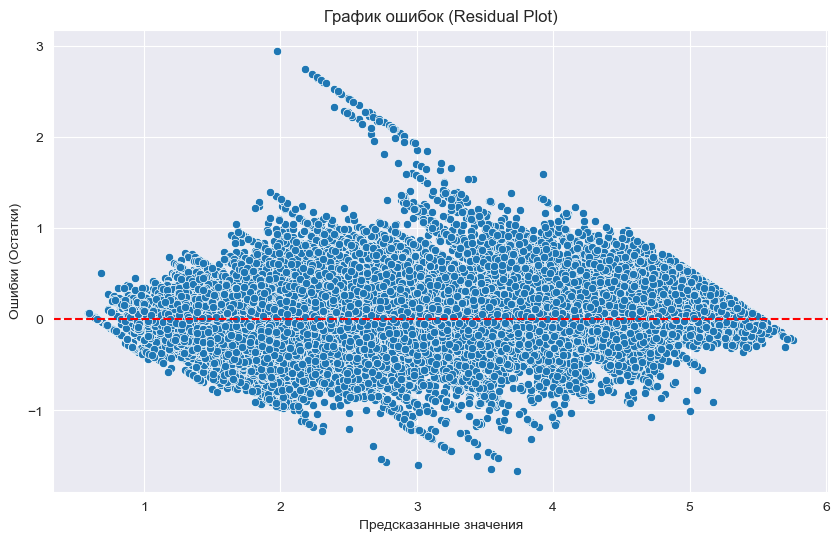

In [24]:
from sklearn.metrics import mean_squared_error


# 1. График ошибок (Residual Plot)
residuals = y_test - y_pred  # Вычисляем ошибки (остатки)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Ошибки (Остатки)")
plt.title("График ошибок (Residual Plot)")
plt.show()



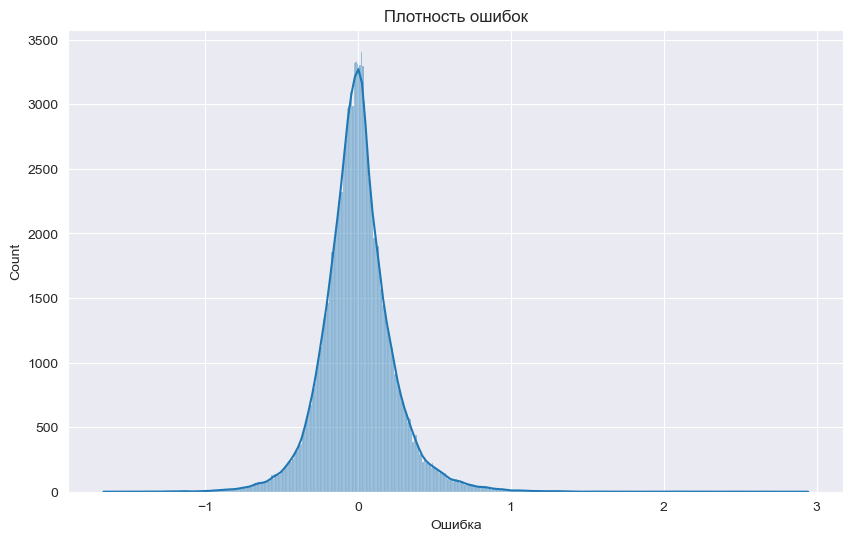

In [25]:
# 2. График плотности ошибок
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Ошибка")
plt.title("Плотность ошибок")
plt.show()

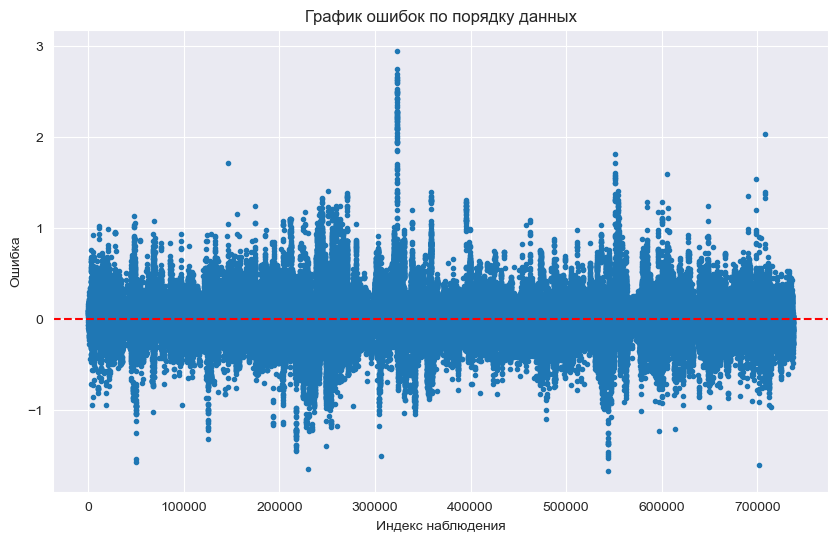

In [26]:
# 3. График ошибок по порядку данных
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='', markersize=3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Индекс наблюдения")
plt.ylabel("Ошибка")
plt.title("График ошибок по порядку данных")
plt.show()

На основе предоставленных графиков ошибок можно сделать следующие выводы:

График ошибок по порядку данных: Ошибки распределены вокруг нуля без явного смещения, однако имеются отдельные всплески значений ошибки. Это говорит о том, что модель в среднем предсказывает с небольшой ошибкой, но на некоторых наблюдениях ошибка заметно выше.

Плотность ошибок: Большинство ошибок сосредоточено около нуля, что подтверждает высокую точность модели. Небольшое количество крупных ошибок может указывать на сложные для модели данные или на выбросы в данных.

Residual Plot (график остатков): Ошибки имеют тенденцию увеличиваться по мере роста предсказанного значения, что может свидетельствовать о небольшом недооценивании высоких значений. Однако в целом распределение ошибок вокруг нуля остается симметричным, что говорит об отсутствии сильного смещения.

Краткий вывод:
Модель демонстрирует высокую точность и небольшие ошибки в среднем, хотя на некоторых наблюдениях возникают всплески ошибок, особенно на больших значениях предсказаний.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Подготовка данных
X = data_cl.drop('% Silica Concentrate', axis=1).values  # Матрица признаков
y = data_cl['% Silica Concentrate'].values  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Переносим данные в тензоры PyTorch и отправляем их на устройство (GPU)
device = torch.device("cuda")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Определение архитектуры нейронной сети с 15 слоями и фиксированным количеством нейронов
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc8 = nn.Linear(128, 128)
        self.fc9 = nn.Linear(128, 128)
        self.fc10 = nn.Linear(128, 128)
        self.fc11 = nn.Linear(128, 128)
        self.fc12 = nn.Linear(128, 128)
        self.fc13 = nn.Linear(128, 128)
        self.fc14 = nn.Linear(128, 128)
        self.fc15 = nn.Linear(128, 1)  # Выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = torch.relu(self.fc10(x))
        x = torch.relu(self.fc11(x))
        x = torch.relu(self.fc12(x))
        x = torch.relu(self.fc13(x))
        x = torch.relu(self.fc14(x))
        x = self.fc15(x)  # Линейный выход для регрессии
        return x

# Инициализация модели, функции потерь и оптимизатора
input_dim = X_train.shape[1]
model = RegressionNN(input_dim).to(device)  # Переносим модель на GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Вывод метрики каждые 100 эпох
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = predictions.cpu().detach().numpy()  # Переносим предсказания на CPU для оценки

# Вычисление метрик
y_test_cpu = y_test_tensor.cpu().numpy()  # Переносим истинные значения на CPU
mse = mean_squared_error(y_test_cpu, predictions)
mae = mean_absolute_error(y_test_cpu, predictions)
r2 = r2_score(y_test_cpu, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


Epoch [100/5000], Loss: 0.3870
Epoch [200/5000], Loss: 0.3345
Epoch [300/5000], Loss: 0.2898
Epoch [400/5000], Loss: 0.2661
Epoch [500/5000], Loss: 0.2555
Epoch [600/5000], Loss: 0.2330
Epoch [700/5000], Loss: 0.2269
Epoch [800/5000], Loss: 0.2205
Epoch [900/5000], Loss: 0.2008
Epoch [1000/5000], Loss: 0.1995
Epoch [1100/5000], Loss: 0.1995
Epoch [1200/5000], Loss: 0.1882
Epoch [1300/5000], Loss: 0.1869
Epoch [1400/5000], Loss: 0.1755
Epoch [1500/5000], Loss: 0.1769
Epoch [1600/5000], Loss: 0.1745
Epoch [1700/5000], Loss: 0.1583
Epoch [1800/5000], Loss: 0.1434
Epoch [1900/5000], Loss: 0.1436
Epoch [2000/5000], Loss: 0.1327
Epoch [2100/5000], Loss: 0.1344
Epoch [2200/5000], Loss: 0.1380
Epoch [2300/5000], Loss: 0.1219
Epoch [2400/5000], Loss: 0.1306
Epoch [2500/5000], Loss: 0.1199
Epoch [2600/5000], Loss: 0.1133
Epoch [2700/5000], Loss: 0.1137
Epoch [2800/5000], Loss: 0.1102
Epoch [2900/5000], Loss: 0.1085
Epoch [3000/5000], Loss: 0.1018
Epoch [3100/5000], Loss: 0.1050
Epoch [3200/5000]

In [36]:
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 0.2730821967124939
MAPE: 8.326269152293431


Best RMSE: 0.23493130620862962  -----    RMSE: 0.2730821967124939
                                              
MAE: 0.1665005772494476  -----           MAE: 0.16833505034446716 

R2 Score: 0.9563287541532196  -----     R² Score: 0.9409933686256409  

MAPE: 8.326269152293431%    -----        MAPE: 8.326269152293431           




На основе сравнения метрик для моделей LightGBM и PyTorch можно сделать следующие выводы:

RMSE: LightGBM показывает лучшую точность с RMSE = 0.2349 по сравнению с RMSE = 0.2731 у PyTorch. Это говорит о том, что LightGBM лучше предсказывает значения с меньшей среднеквадратичной ошибкой.

MAE: Средняя абсолютная ошибка также меньше у модели LightGBM (MAE = 0.1665) по сравнению с PyTorch (MAE = 0.1683). Это подтверждает, что LightGBM более точно предсказывает средние значения.

R² Score: Модель LightGBM имеет немного более высокое значение R² (0.9563) по сравнению с PyTorch (0.9410). Это указывает на то, что LightGBM лучше объясняет дисперсию данных, что свидетельствует о более высокой объясняющей способности.

MAPE: Средняя абсолютная процентная ошибка одинакова у обеих моделей (8.32%), что указывает на схожий уровень процентной точности предсказаний.

Заключение
Модель на основе LightGBM демонстрирует лучшие результаты по большинству метрик (RMSE, MAE, R²) по сравнению с нейронной сетью PyTorch. LightGBM более точна и лучше справляется с задачей предсказания. PyTorch может потребовать дальнейшей настройки гиперпараметров или изменения архитектуры для улучшения результатов.

In [34]:
# Сохранение всей модели целиком
torch.save(model, 'regression_nn_model.pth')


In [ ]:
# Загрузка всей модели
model = torch.load('regression_nn_model.pth')
model.to(device)  # Переносим на GPU, если нужно
model.eval()  # Переключаем в режим оценки
